In [1]:
import logging
from pathlib import Path

from torchmetrics import F1Score

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import wandb
from torch import optim
from tqdm import tqdm

from torchsummary import summary

from dice_score import dice_loss
from OSSE_DataLoader import get_data_loaders, get_xarray, normalize_osse, SegmentationTransform
from unet import UNet

In [2]:
batch_size = 8


INPUT_IMAGE_HEIGHT = 357
INPUT_IMAGE_WIDTH = 717

augmentation = transforms.Compose(
    [
        transforms.RandomRotation(180),
        transforms.RandomCrop((256, 256)),
    ]
)


OSSE_train, eddies_train, OSSE_test = get_xarray()

OSSE_train, OSSE_test_norm, *_ = normalize_osse(OSSE_train, OSSE_test)


train_dataloader, val_dataloader = get_data_loaders(
    batch_size, OSSE_train, eddies_train, 0, 0, augmentations=augmentation
)

train_dataloader_not_augmented, val_dataloader_not_augmented = get_data_loaders(
    batch_size, OSSE_train, eddies_train, 0, 0
)

data_iter = iter(train_dataloader)

features, labels = next(data_iter)


In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

from dice_score import multiclass_dice_coeff, dice_coeff


@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    f1_score = 0

    # iterate over the validation set
    # with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    for (image, mask_true) in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        # image, mask_true = batch['image'], batch['mask']

        # move images and labels to correct device and type
        # image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)

        # predict the mask
        mask_pred = net(image)

        if net.n_classes == 1:
            assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
            mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
            # compute the Dice score
            dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
        else:
            assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
            # convert to one-hot format
            # mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
            # mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

            y_true = torch.squeeze(mask_true, 1).long()

            mask_pred = F.softmax(mask_pred, dim=1).float()
            mask_true = F.one_hot(y_true, 3).permute(0, 3, 1, 2).float()


            # mask_true = F.one_hot(mask_true.squeeze(1), net.n_classes).float()
            # mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
            # compute the Dice score, ignoring background
            dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)
            
            # try:
            pred = mask_pred.argmax(dim=1)

            # f1_score += score_f1(mask_pred, mask_true)
            f1_score += score_f1(pred, y_true)
            # except Exception as e:
            #     print(e)
            #     pass

    f1_score = f1_score / num_val_batches

    net.train()
    return dice_score / max(num_val_batches, 1), f1_score 

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

device = torch.device("mps")

model = UNet(n_channels=4, n_classes=3, bilinear=False)
model =model.to(device)
# model.to("mps")

print(device)

# summary(model, input_size=(4, 357//4, 717//4))

mps


In [6]:
# count number of data points in each class
def count_classes(data_loader):
    class_count = [0, 0, 0]
    for _, labels in data_loader:
        for i in range(3):
            class_count[i] += (labels == i).sum().item()
    return class_count

class_count = count_classes(train_dataloader_not_augmented)
print(class_count)

# define weights for each class
weights = 1 - (torch.tensor(class_count, dtype=torch.float) / sum(class_count))
weights = weights.to(device)
print(weights)



[61405926, 5671717, 5617553]
tensor([0.1553, 0.9220, 0.9227])


In [6]:
# !PYTORCH_ENABLE_MPS_FALLBACK=1

model.train()
loss = 0

criterion = nn.CrossEntropyLoss(weight=weights)

f1_score = 0

score_f1 = F1Score(task ="multiclass",  num_classes=3, average="weighted").to(device)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

for features, labels in train_dataloader:
    print(features.shape)
    print(labels.shape)

    features = features.to(device)
    true_masks = labels.to(device)

    masks_pred = model(features)

    # y_true = torch.squeeze(true_masks, 1).long()

    # loss += criterion(masks_pred, y_true)
    # loss += dice_loss(
    #     F.softmax(masks_pred, dim=1).float(),
    #     F.one_hot(y_true, model.n_classes).permute(0, 3, 1, 2).float(),
    #     multiclass=True
    # )

    y_true = torch.squeeze(true_masks, 1).long()

    masks_pred = F.softmax(masks_pred, dim=1).float()
    mask_true = F.one_hot(y_true, 3).permute(0, 3, 1, 2).float()


    # mask_true = F.one_hot(mask_true.squeeze(1), net.n_classes).float()
    # mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
    # compute the Dice score, ignoring background
    # dice_score += multiclass_dice_coeff(masks_pred[:, 1:], true_masks[:, 1:], reduce_batch_first=False)
    
    # try:
    pred = masks_pred.argmax(dim=1)

    # f1_score += score_f1(mask_pred, mask_true)

    print(pred.shape)
    print(y_true.shape)

    # f1_score += score_f1(pred, y_true.permute(0, 3, 1, 2).long())
    f1_score += score_f1(pred, y_true)
    # except Exception as e:
    #     print("Error")
    #     print(e)
    #     pass


    print(loss)

print(f1_score)


torch.Size([8, 4, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])
torch.Size([8, 256, 256])
0
torch.Size([8, 4, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])
torch.Size([8, 256, 256])
0
torch.Size([8, 4, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])
torch.Size([8, 256, 256])
0
torch.Size([8, 4, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])
torch.Size([8, 256, 256])
0
torch.Size([8, 4, 256, 256])
torch.Size([8, 1, 256, 256])


KeyboardInterrupt: 

In [ ]:
features, labels = next(data_iter)

features = features.to(device, dtype=torch.float32)
labels= labels.to(device)

model.train()


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
features.shape

torch.Size([4, 4, 89, 179])

In [ ]:
model(features)

tensor([[[[ 1.1164e-01, -1.8179e-02, -3.9206e-03,  ..., -8.2241e-01,
           -1.8600e-01, -3.6633e-01],
          [ 2.0391e-01, -8.0261e-02,  1.2172e-01,  ..., -9.3781e-01,
           -5.8848e-01, -1.5908e-01],
          [ 1.6411e-01,  6.3528e-02,  2.6253e-02,  ..., -3.0476e-01,
            1.6268e-01,  6.7472e-04],
          ...,
          [ 2.9629e-01, -3.8887e-02,  1.3487e-01,  ..., -2.1646e-01,
            5.2838e-01,  5.0821e-01],
          [ 1.9403e-01, -4.2702e-01, -1.8601e-01,  ...,  3.6195e-01,
            2.9550e-01, -7.9762e-02],
          [ 2.2907e-01, -1.2006e-01, -3.0962e-01,  ...,  2.1625e-01,
            2.1107e-03,  2.0906e-01]],

         [[-1.9044e-01,  2.4912e-01,  5.2261e-02,  ..., -2.1875e-02,
            1.5649e-01,  4.6888e-02],
          [ 3.9567e-02,  1.0505e-01,  1.7893e-01,  ..., -2.2845e-01,
           -1.0090e-01, -4.7845e-02],
          [-5.8220e-02,  3.5523e-01,  2.9870e-01,  ..., -1.0247e-02,
            2.1321e-03,  7.1031e-02],
          ...,
     

In [1]:
len(train_dataloader)

NameError: name 'train_dataloader' is not defined

In [7]:
dir_img = Path('./data/imgs/')
dir_mask = Path('./data/masks/')
dir_checkpoint = Path('./checkpoints/')

epochs = 2000
learning_rate = 1e-3
val_percent = 0.1
save_checkpoint = True
img_scale = 1
amp = False
weight_decay = 1e-8
momentum = 0.999
gradient_clipping = 1

train_loader, val_loader = train_dataloader, val_dataloader

score_f1 = F1Score(task ="multiclass",  num_classes=3, average="macro").to(device)

# n_train = int(len(OSSE_train) * 0.8)
n_train = len(OSSE_train)
n_val = int(len(OSSE_test) * 0.2)

# (Initialize logging)
# experiment = wandb.init(project='U-Net', resume='auto', anonymous='must')
experiment = wandb.init(project='U-Net', resume='never')
experiment.config.update(
    dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
            val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
)

logging.info(f'''Starting training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {learning_rate}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_checkpoint}
    Device:          {device.type}
    Images scaling:  {img_scale}
    Mixed Precision: {amp}
''')

# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
# optimizer = optim.RMSprop(model.parameters(),
#                             # lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
#                             lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=6, factor=0.3)  # goal: maximize Dice score
# grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

# criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.8, 0.8]))
criterion = nn.CrossEntropyLoss()
global_step = 0

# print("là")

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    # print("ici")
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:

        for (images, true_masks) in train_loader:
            # images, true_masks = batch['image'], batch['mask']

            # print(images.shape)
            # print(true_masks.shape)

            # assert images.shape[1] == model.n_channels, \
            #     f'Network has been defined with {model.n_channels} input channels, ' \
            #     f'but loaded images have {images.shape[1]} channels. Please check that ' \
            #     'the images are loaded correctly.'

            # images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            # images = images.to(device=device, dtype=torch.float32)
            # true_masks = true_masks.to(device=device, dtype=torch.long)
            images = images.to(device)

            true_masks = true_masks.to(device)
            masks_pred = model(images)

            # print("jsuis là fréro")

            # with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
            # print("juste ici")
            
            # if model.n_classes == 1:
            #     loss = criterion(masks_pred.squeeze(1), true_masks.float())
            #     loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
            # else:
            #     # loss = criterion(masks_pred, true_masks)
            #     # print(masks_pred.shape)
            #     # print(true_masks.shape)

            #     y_true = torch.squeeze(true_masks, 1)
            #     # print(y_true.shape)
            #     print("là bas")
            #     # loss = criterion(masks_pred, F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float())
            #     loss = criterion(masks_pred, y_true.float())
            #     loss += dice_loss(
            #         F.softmax(masks_pred, dim=1).float(),
            #         # F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
            #         F.one_hot(y_true, model.n_classes).float(),
            #         multiclass=True
            #     )


            y_true = torch.squeeze(true_masks, 1).long()

            loss = criterion(masks_pred, y_true)
            # loss += dice_loss(
            #     F.softmax(masks_pred, dim=1).float(),
            #     F.one_hot(y_true, model.n_classes).permute(0, 3, 1, 2).float(),
            #     multiclass=True
            # )


            # print("here")

            optimizer.zero_grad(set_to_none=True)
            # grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            # grad_scaler.step(optimizer)
            # loss.step(optimizer)
            # grad_scaler.update()
            loss.backward()
            optimizer.step()
            
            # print("there")

            # pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            # experiment.log({
            #     'train loss': loss.item(),
            #     'step': global_step,
            #     'epoch': epoch
            # })
            experiment.log({
                'train loss': loss.item(),
                'step': global_step,
                'epoch': epoch
            })

            # pbar.set_postfix(**{'loss (batch)': loss.item()})

            # Evaluation round
            # division_step = (n_train // (5 * batch_size))
            # print("n_train", n_train)
            
            # print("global_step", global_step)

    # division_step = 8

    # if division_step > 0:
    #     if global_step % division_step == 0:
    histograms = {}
    for tag, value in model.named_parameters():
        tag = tag.replace('/', '.')
        if not torch.isinf(value).any():
            histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
        if not torch.isinf(value.grad).any():
            histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

    val_score, f1_score = evaluate(model, val_loader, device, amp)
    print("val_score", val_score)
    print("f1_score", f1_score)

    scheduler.step(val_score)

    logging.info('Validation Dice score: {}'.format(val_score))
    try:
        experiment.log({
        # logging.info({
            'learning rate': optimizer.param_groups[0]['lr'],
            'validation Dice': val_score,
            'images': wandb.Image(images[0].cpu()),
            'masks': {
                'true': wandb.Image(true_masks[0].float().cpu()),
                'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
            },
            'step': global_step,
            'epoch': epoch,
            'f1_score': f1_score,
            **histograms
        })
    except:
        pass

    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        state_dict = model.state_dict()
        # state_dict['mask_values'] = dataset.mask_values
        torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
        logging.info(f'Checkpoint {epoch} saved!')



epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train loss,█▇▆▅▄▄▄▄▄▃▃▃▃▄▃▃▂▄▂▃▃▃▂▄▁▂▁
epoch,1
f1_score,0.5914
learning rate,0.001
step,27
train loss,0.3448
validation Dice,0.2768


Validation round:   0%|          | 0/8 [00:00<?, ?batch/s]/opt/homebrew/Caskroom/miniforge/base/envs/hackathon-sdd/lib/python3.9/site-packages/torch/functional.py:791: UserWarning: The operator 'aten::_unique2' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  output, inverse_indices, counts = torch._unique2(


val_score tensor(0.1500, device='mps:0')
f1_score tensor(0.3070, device='mps:0')


Epoch 2/2000:   0%|          | 0/4 [02:05<?, ?img/s]


val_score tensor(0.1773, device='mps:0')
f1_score tensor(0.4284, device='mps:0')


Epoch 3/2000:   0%|          | 0/4 [02:04<?, ?img/s]


val_score tensor(0.1924, device='mps:0')
f1_score tensor(0.4561, device='mps:0')


Epoch 4/2000:   0%|          | 0/4 [01:04<?, ?img/s]


KeyboardInterrupt: 

In [54]:
# model = UNet(n_channels=4, n_classes=3, bilinear=False)

# load model from checkpoint
state_dict = torch.load('dieu/checkpoint_epoch101.pth', map_location=device)
model.load_state_dict(state_dict)




<All keys matched successfully>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
selected_var = ["vomecrtyT", "vozocrtxT", "sossheig", "votemper"]

X_test = torch.tensor(OSSE_test_norm.get(selected_var).to_array().to_numpy())
X_test = X_test.permute(1, 0, 2, 3)

copy_X_test = X_test.clone()

X_test = X_test.nan_to_num(0)

features =X_test[:, :, :, :]

model.to("cpu")
features.to("cpu")
model.eval()

logits = torch.empty(features.shape)

with torch.no_grad():
    # iterate over the test dataset and add results to logits
    for i in range(0, features.shape[0], 4):
        print(i)
        output = model(features[i:i+4, :,:,:])# softmax
        logits[i:i+4, :, :, :] = torch.argmax(output,dim=1, keepdim=True)


    # output = model(features[0:4, :,:,:])# softmax
    # logits = torch.argmax(output,dim=1, keepdim=True)

plt.imshow(features[0, 0, :, :].cpu().numpy())
plt.show()
# # show the label of 1st sample
# plt.imshow(labels[1, 0, :, :].cpu().numpy())
# plt.show()
# show the predicted label of 1st sample
plt.imshow(logits[0, 0, :, :].cpu().numpy())
plt.show()

0
4
8
12
16


In [25]:
features.shape

torch.Size([72, 4, 357, 717])

In [24]:
# logits

torch.Size([72, 4, 357, 717])

In [46]:
logits2 = logits[:, 0, :, :]

In [47]:
np.unique(logits2)

array([0., 1., 2.], dtype=float32)

In [20]:
# output.shape


# logits = torch.argmax(,dim=1, keepdim=True)

SyntaxError: invalid syntax (801809199.py, line 4)

In [16]:
np.unique(logits.numpy())

array([2])

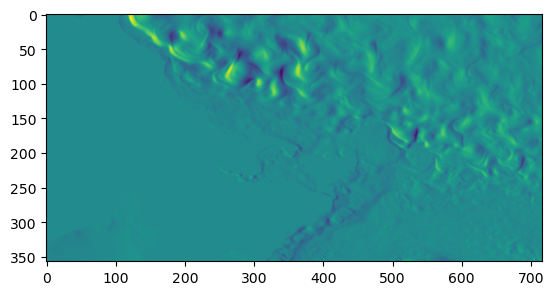

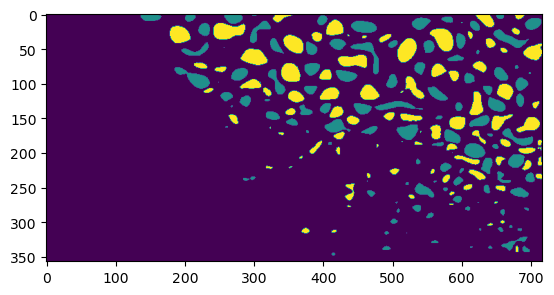

In [32]:
plt.imshow(features[1, 0, :, :].cpu().numpy())
plt.show()
# # show the label of 1st sample
# plt.imshow(labels[1, 0, :, :].cpu().numpy())
# plt.show()
# show the predicted label of 1st sample
plt.imshow(logits[1, 0, :, :].cpu().numpy())
plt.show()

In [40]:
logits.shape
logits

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [36]:
# np.unique(logits.numpy())
# logits.shape

logits2 = torch.argmax(logits, dim=1)


In [37]:
np.unique(logits2.numpy())

array([0])

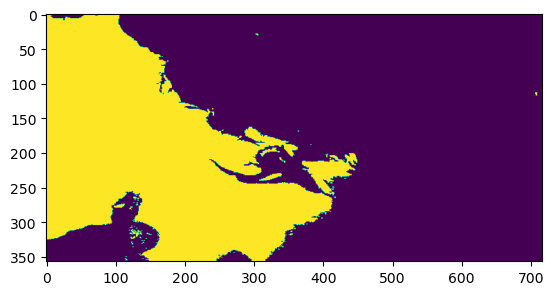

In [49]:
# logits2 = torch.argmax(logits, dim=1, keepdim=True)

predictions = copy_X_test[:, 0, :, :].flatten().isnan() * 999

predictions[logits2.flatten() == 1] = 1
predictions[logits2.flatten() == 2] = 2

np.unique(predictions.cpu().numpy())

plt.imshow(predictions.reshape(72, 357, 717)[0, :, :])

In [50]:
idx_csv = []
for Id_tp in range(72):
    for Id_lat in range(357):
        for Id_lon in range(717):
            idx_csv.append(f'{Id_tp}_{Id_lat}_{Id_lon}')

# when copy_X_test is nan change values of ypred to 999
# ypred = model(X_test)
# logits = torch.argmax(output,dim=1, keepdim=True)
# ypred = logits.flatten().cpu().numpy()

submit_predictions = predictions.cpu().numpy().copy()

In [51]:
import pandas as pd

In [52]:
df = pd.DataFrame({'Id': idx_csv, 'Category': submit_predictions})
df.to_csv('submission2.csv', index=False)
df.head()

,Id,Category
0,0_0_0,999
1,0_0_1,999
2,0_0_2,999
3,0_0_3,999
4,0_0_4,999


In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
y_true = labels.cpu().numpy().flatten()
y_pred = logits.cpu().numpy().flatten()
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.show()